In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 3)  # (width, height) in inches
from mzsql import *

## Create DuckDB for querying

Initially ignore indexing/organizing and just write as in MS file

In [2]:
import datetime
print(datetime.datetime.now()) # Was VERY slow the first time I tried to render this??
turn_mzml_duckdb("../demo_data/180205_Poo_TruePoo_Full1.mzML", 
                 "../demo_data/180205_Poo_TruePoo_Full1.duckdb")
print(datetime.datetime.now())

2024-11-19 16:27:22.417314


/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_pds.to_sql("MS1", conn, if_exists="append", index=False)


2024-11-19 20:14:32.937986


## Query the database

/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  query_data = pd.read_sql_query(query, conn)


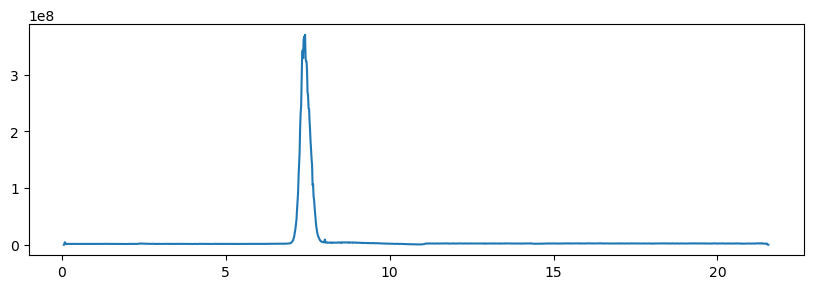

In [3]:
chrom_data = get_chrom_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 118.0865, 10)
plt.plot(chrom_data["rt"], chrom_data["int"])

/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:54: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  spectrum_data = pd.read_sql_query(query, conn)


<StemContainer object of 3 artists>

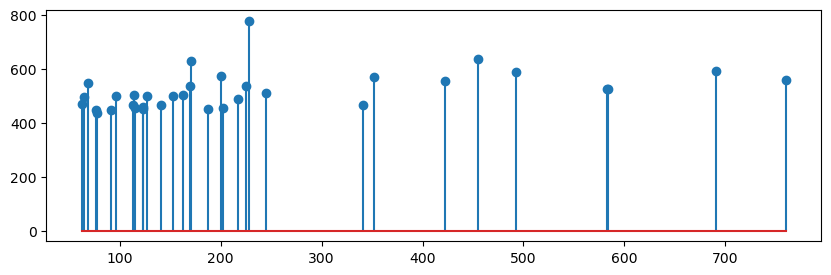

In [4]:
spec_data = get_spec_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 1)
plt.stem(spec_data["mz"], spec_data["int"])

/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rt_range_data = pd.read_sql_query(query, conn)


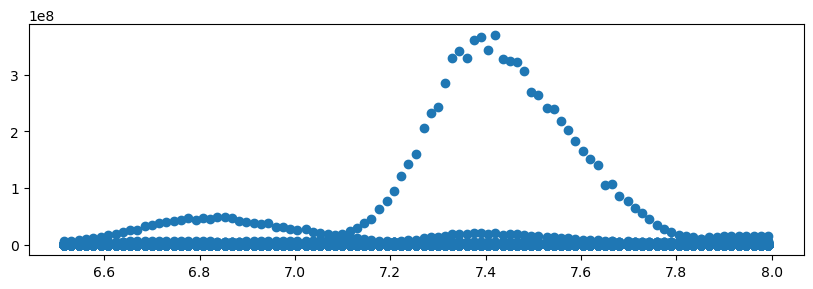

In [5]:
rtrange_data = get_rtrange_duckdb('../demo_data/180205_Poo_TruePoo_Full1.duckdb', 6.5, 8)
plt.scatter(rtrange_data["rt"], rtrange_data["int"])

## Comparison to SQLite

In [6]:
import timeit

/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:54: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  spectrum_data = pd.read_sql_query(query, conn)


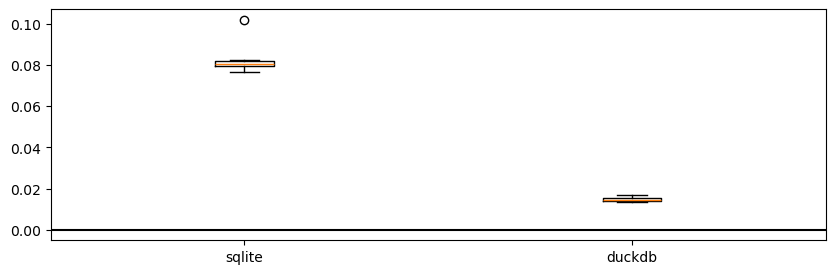

In [17]:
sqlite_spec = timeit.repeat('get_spec_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 1)', globals=globals(), number=1, repeat=10)
duckdb_spec = timeit.repeat('get_spec_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 1)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_spec, duckdb_spec], tick_labels=["sqlite", "duckdb"])
plt.axhline(y=0, color="k")
plt.show()

/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  query_data = pd.read_sql_query(query, conn)


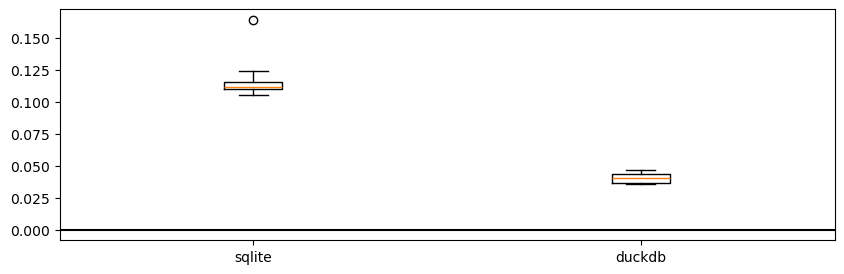

In [16]:
sqlite_chrom = timeit.repeat('get_chrom_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 118.0865, 10)', globals=globals(), number=1, repeat=10)
duckdb_chrom = timeit.repeat('get_chrom_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 118.0865, 10)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_chrom, duckdb_chrom], tick_labels=["sqlite", "duckdb"])
plt.axhline(y=0, color="k")
plt.show()

/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rt_range_data = pd.read_sql_query(query, conn)


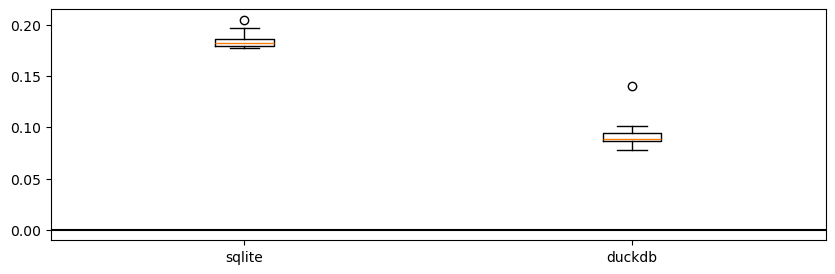

In [9]:
sqlite_rtrange = timeit.repeat('get_rtrange_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 6.5, 8)', globals=globals(), number=1, repeat=10)
duckdb_rtrange = timeit.repeat('get_rtrange_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 6.5, 8)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_rtrange, duckdb_rtrange], tick_labels=["sqlite", "duckdb"])
plt.axhline(y=0, color="k")
plt.show()

## Improvements from ordering the MS1 table before writing to DuckDB?

In [10]:
print(datetime.datetime.now())
turn_mzml_duckdb("../demo_data/180205_Poo_TruePoo_Full1.mzML", 
                 "../demo_data/180205_Poo_TruePoo_Full1.ord_duckdb", 
                 ordered=True)
print(datetime.datetime.now())

2024-11-19 20:14:42.007737


/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_pds.sort_values(by="mz").to_sql("MS1", conn, if_exists="append", index=False)


2024-11-20 00:07:28.127691


/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:54: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  spectrum_data = pd.read_sql_query(query, conn)


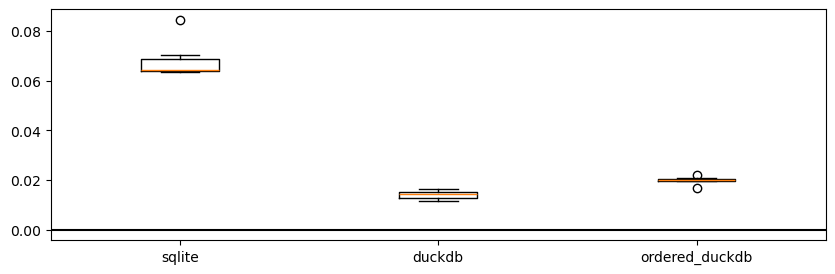

In [11]:
sqlite_spec = timeit.repeat('get_spec_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 1)', globals=globals(), number=1, repeat=10)
duckdb_spec = timeit.repeat('get_spec_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 1)', globals=globals(), number=1, repeat=10)
ord_duckdb_spec = timeit.repeat('get_spec_duckdb("../demo_data/180205_Poo_TruePoo_Full1.ord_duckdb", 1)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_spec, duckdb_spec, ord_duckdb_spec], tick_labels=["sqlite", "duckdb", "ordered_duckdb"])
plt.axhline(y=0, color="k")
plt.show()

/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  query_data = pd.read_sql_query(query, conn)


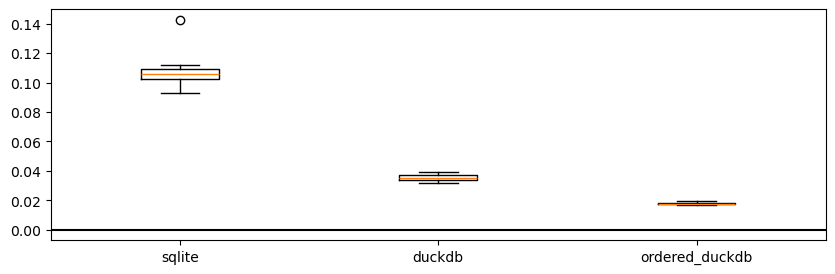

In [14]:
sqlite_chrom = timeit.repeat('get_chrom_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 118.0865, 10)', globals=globals(), number=1, repeat=10)
duckdb_chrom = timeit.repeat('get_chrom_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 118.0865, 10)', globals=globals(), number=1, repeat=10)
ord_duckdb_chrom = timeit.repeat('get_chrom_duckdb("../demo_data/180205_Poo_TruePoo_Full1.ord_duckdb", 118.0865, 10)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_chrom, duckdb_chrom, ord_duckdb_chrom], tick_labels=["sqlite", "duckdb", "ordered_duckdb"])
plt.axhline(y=0, color="k")
plt.show()

/home/wkumler/mzsql/src/mzsql/duckdb_functions.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rt_range_data = pd.read_sql_query(query, conn)


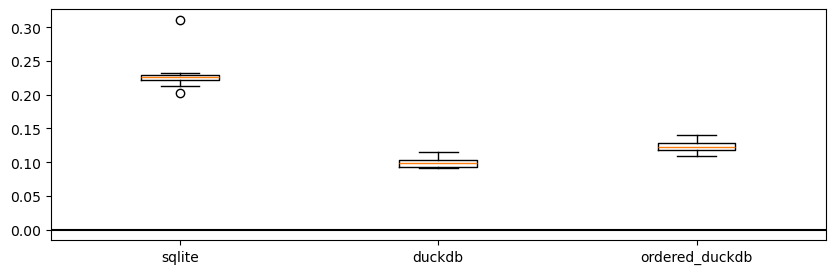

In [15]:
sqlite_rtrange = timeit.repeat('get_rtrange_sqlite("../demo_data/180205_Poo_TruePoo_Full1.sqlite", 6.5, 8)', globals=globals(), number=1, repeat=10)
duckdb_rtrange = timeit.repeat('get_rtrange_duckdb("../demo_data/180205_Poo_TruePoo_Full1.duckdb", 6.5, 8)', globals=globals(), number=1, repeat=10)
ord_duckdb_rtrange = timeit.repeat('get_rtrange_duckdb("../demo_data/180205_Poo_TruePoo_Full1.ord_duckdb", 6.5, 8)', globals=globals(), number=1, repeat=10)
plt.boxplot([sqlite_rtrange, duckdb_rtrange, ord_duckdb_rtrange], tick_labels=["sqlite", "duckdb", "ordered_duckdb"])
plt.axhline(y=0, color="k")
plt.show()